In [2]:
from pathlib import Path
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from IPython.display import display


In [3]:
INJECTION_DATA_DIR = Path('data/inj/')
PORE_PRESSURE_DATA_DIR = Path('data/pp/')
ETAS_DATA_DIR = Path('data/etas1/')

In [4]:

def lat_lon_from_filename(filename):
    fname_split = filename.stem.split('_')    
    lat, lon = fname_split[1], fname_split[2]
    return lat, lon
    
def parse_pp_data(filename):
    """
    Returns longitude, lattitude, pore pressure dataframe for a given pore pressure data file
    """    
    df_pp = pd.read_csv(filename, sep=' ', header=None, names=['year_month', 'pp'])
    df_pp = df_pp.groupby('year_month').agg(sum).reset_index()

    lat, lon = lat_lon_from_filename(filename)
    return lat, lon, df_pp


In [5]:
# prepare pore pressure data
pore_pressure_data_files = list(PORE_PRESSURE_DATA_DIR.glob('*.txt'))
PP_LAT_LON_DATA = {}
for filename in pore_pressure_data_files:
    lat, lon, df_pp = parse_pp_data(filename)
    PP_LAT_LON_DATA[lat, lon] = df_pp


In [29]:
# convert each row into a separate dataframe
ALL_YEAR_MONTH = [2011.  , 2011.08, 2011.17, 2011.25, 2011.33, 2011.42, 2011.5 ,
       2011.58, 2011.67, 2011.75, 2011.83, 2011.92, 2012.  , 2012.08,
       2012.17, 2012.25, 2012.33, 2012.42, 2012.5 , 2012.58, 2012.67,
       2012.75, 2012.83, 2012.92, 2013.  , 2013.08, 2013.17, 2013.25,
       2013.33, 2013.42, 2013.5 , 2013.58, 2013.67, 2013.75, 2013.83,
       2013.92, 2014.  , 2014.08, 2014.17, 2014.25, 2014.33, 2014.42,
       2014.5 , 2014.58, 2014.67, 2014.75, 2014.83, 2014.92, 2015.  ,
       2015.08, 2015.17, 2015.25, 2015.33, 2015.42, 2015.5 , 2015.58,
       2015.67, 2015.75, 2015.83, 2015.92, 2016.  , 2016.08, 2016.17,
       2016.25, 2016.33, 2016.42, 2016.5 , 2016.58, 2016.67, 2016.75,
       2016.83, 2016.92, 2017.  , 2017.08, 2017.17, 2017.25, 2017.33,
       2017.42, 2017.5 , 2017.58, 2017.67, 2017.75, 2017.83, 2017.92,
       2018.  , 2018.08, 2018.17, 2018.25, 2018.33, 2018.42, 2018.5 ,
       2018.58, 2018.67, 2018.75, 2018.83, 2018.92]


def round_month(date, up=True):
    month_decimal = np.array([0., 0.08, 0.17, 0.25, 0.33, 0.42, 0.5 ,0.58, 0.67, 0.75, 0.83, 0.92])
    year_month = 2010 + date/365
    # get only decimal part (month)
    month = year_month % 1
    year = year_month - month
#     print(year_month, year, month)

    # custom rounding
    if up:
        month = month_decimal[month_decimal >= month]
        if len(month):
            month = month[0]
        else:
            # value must be greater than 0.92(last month), so we'll roll over to next year
            year += 1
            month = 0
    else:
        month = month_decimal[month_decimal <= month][-1]
    return year+month

df_temp = []

def parse_etas1_data(filename):
    global df_temp
    
    df_etas1 = pd.read_csv(filename, delim_whitespace=True, names=['first_event_number', 'last_event_number','starting_date','ending_date','AIC','K','mu'])
    # calculate lambda    
    df_etas1['lambda'] = (df_etas1['last_event_number'] - df_etas1['first_event_number'] + 1) \
                         / (df_etas1['ending_date'] - df_etas1['starting_date'])
    # convert start/end date from dates.float to year/month/date format
    # round up start date
    new_start_date = df_etas1.starting_date.apply(lambda x: round_month(x, up=True))
    # round down end date
    new_end_date = df_etas1.ending_date.apply(lambda x: round_month(x, up=False))

    df_etas1['new_start_date'] = new_start_date
    df_etas1['new_end_date'] = new_end_date
    
    def avg_row(row):
        non_zero_count = (row>0).sum()
        if non_zero_count > 0:
            avg = row.sum()/non_zero_count
        else:
            return np.nan
        return avg


    def get_avg_df(df_etas1, column):
        df = pd.DataFrame(ALL_YEAR_MONTH, columns=['year_month'])
        df = df.set_index('year_month')
        for idx, row in df_etas1.iterrows():
            df[idx] = 0       
            df.loc[(df.index >= row.new_start_date) & \
                   (df.index <= row.new_end_date), idx] = row[column]

        df_temp = df

        df_avg = df.apply(avg_row, axis=1)
        # rename column to lamda
        df_avg.name = column
        df_avg = df_avg.reset_index()
        return df_avg

    df_avg_lambda = get_avg_df(df_etas1, 'lambda')
    df_avg_mu = get_avg_df(df_etas1, 'mu')
    lat, lon = lat_lon_from_filename(filename)
    return lat, lon, df_etas1, df_avg_lambda, df_avg_mu


In [30]:
# prepare etas1 mu,K,lambda data
etas1_data_files = list(ETAS_DATA_DIR.glob('*.etas1'))
ETAS1_LAT_LON_DATA = {}
for filename in etas1_data_files:
    lat,lon,df_etas1, df_avg_lambda, df_avg_mu = parse_etas1_data(filename)
    ETAS1_LAT_LON_DATA[lat, lon] = (df_etas1, df_avg_lambda, df_avg_mu)

<AxesSubplot:xlabel='year_month'>

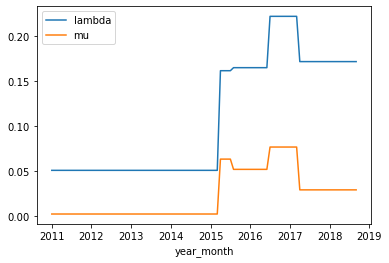

In [35]:
fig, ax = plt.subplots()
df_avg_lambda.plot(ax=ax, x='year_month')
df_avg_mu.plot(ax=ax, x='year_month')

In [36]:
def parse_injection_data(filename):
    """
    Returns longitude, lattitude, injection volume dataframe for a given injection volume data file
    """
    df_inj = pd.read_csv(filename, sep=' ', header=None, names=['year_month', 'injection_volume'])

    lat, lon = lat_lon_from_filename(filename)
    return lat, lon, df_inj


In [37]:
# prepare injection data
injection_data_files = list(INJECTION_DATA_DIR.glob('*.txt'))
INJECTION_LAT_LON_DATA = {}
for filename in injection_data_files:
    lat, lon, df_inj = parse_injection_data(filename)
    INJECTION_LAT_LON_DATA[lat, lon] = df_inj



In [38]:
# check to make sure we have injection volume, pp and etas data for all the co-ordinates
assert INJECTION_LAT_LON_DATA.keys() == ETAS1_LAT_LON_DATA.keys()
assert PP_LAT_LON_DATA.keys() == ETAS1_LAT_LON_DATA.keys()


## Doubts
1. Can I get ETAS value as a continuos function for each month? (From where did you get this data?)
2. There are overlapping ETAS/Lambda value for many years/months. Which one should I consider? or should I do an average?
3. Some co-ordinates only have very few ETAS/Lambda values. And some years might not have ETAS value. What should we do then?
4. Should I consider co-ordinates(lat,lon) as part of input. This means we are kind of training one ML model per 2 deg co-ordinate. If we don't consider the lat,lon data then, we assume that ML model generalizes well across co-ordinates and only depends on inj vol and pp.
5. If we consider all years of data per co-ordinate as one input, we'll only have 53 inputs overall. This is very small data for training ML model. We should think of using a sliding window approach ex: 12 month. This gives us a lot more data to train the ML model. 
6. PP values are negative


In [39]:
def plot_etas_single(ax, df_etas1, column, color):
    
    ax.hlines(y = df_etas1[column], xmin = df_etas1.new_start_date, xmax = df_etas1.new_end_date,
              linewidth=0.5, color=color)

    # triangle in center of hline
    x = df_etas1.new_start_date + ((df_etas1.new_end_date - df_etas1.new_start_date) / 2.0)
    y = df_etas1[column]
    ax.scatter(x, y, marker="^", color=color, s=5)



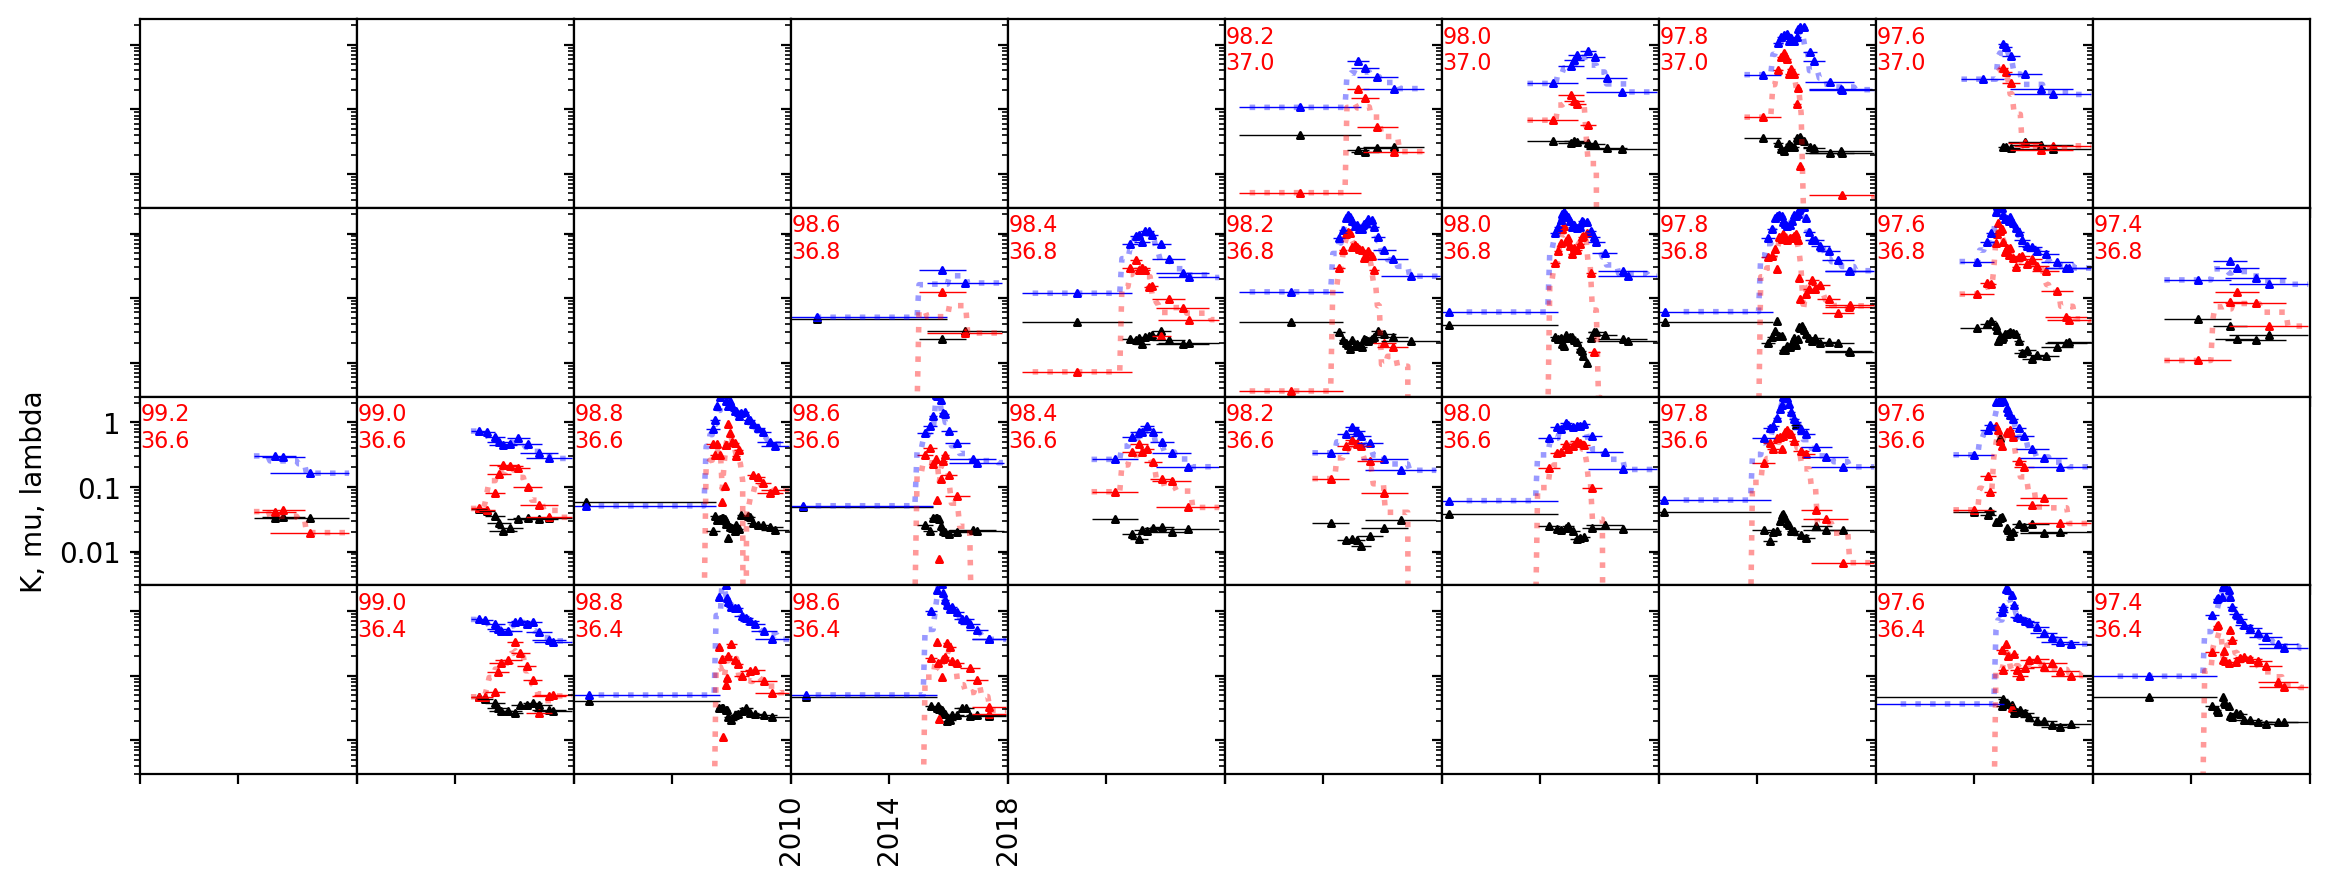

In [45]:
fig, axes = plt.subplots(4, 10, sharex=False, sharey=False, figsize=(14,5), dpi=200)
axes = axes.ravel()

min_k_val = 0.003
max_k_val = 2.5

ax_idx = 0
init=False
for lon in np.arange(37.0, 36.2, -0.2):
    for lat in np.arange(99.2, 97.2, -0.2):
        ax = axes[ax_idx]
        lat_s = "%3.1f"%(lat)
        lon_s = "%3.1f"%(lon)

        if (lat_s,lon_s) in ETAS1_LAT_LON_DATA:
           #plot etas1 mu,K,lambda
            df_etas1, df_avg_lambda, df_avg_mu = ETAS1_LAT_LON_DATA[lat_s, lon_s]
            plot_etas_single(ax, df_etas1, 'K', color='k')
            plot_etas_single(ax, df_etas1, 'mu', color='r')
            plot_etas_single(ax, df_etas1, 'lambda', color='b')
            
            # plot continuos/ average value of lambda
            ax.plot(df_avg_lambda['year_month'], df_avg_lambda['lambda'], 
                    linestyle=':', color='blue', linewidth=2, alpha=0.4)

            # plot continuos/ average value of mu
            ax.plot(df_avg_mu['year_month'], df_avg_mu['mu'], 
                    linestyle=':', color='red', linewidth=2, alpha=0.4)

            # co-ordinate text overlay
            ax.text(2010.00, max_k_val - max_k_val/1.2, '%s\n%s'%(lat_s, lon_s), fontsize=8, color='r')

        # set limit and ticks
        ax.set_yscale("log")
        ax.set_xlim([2010.00, 2018.92])    
        ax.set_ylim([min_k_val, max_k_val])
        yticks = [1, 0.1, 0.01]
        ax.set_yticks(yticks)
        ax.set_xticks([2010.00, 2014.00, 2018.92])
        ax.set_xticklabels([2010, 2014, 2018], rotation=90)

        ax.set_yticklabels([])
        ax.set_xticklabels([])
        # injection volume y axis label
        if lat_s == "99.2" and lon_s == "36.6":
            ax.set_yticklabels(yticks, color='k')
            ax.set_ylabel("K, mu, lambda", color='k')            

        if lat_s == "98.6" and lon_s == "36.4":
            ax.set_xticklabels([2010, 2014, 2018])
        
        ax_idx += 1

# fig.tight_layout()
fig.subplots_adjust(wspace=0, hspace=0)
plt.show()

                   0    1         2
year_month                         
2011.00     0.050615  0.0  0.000000
2011.08     0.050615  0.0  0.000000
2011.17     0.050615  0.0  0.000000
2011.25     0.050615  0.0  0.000000
2011.33     0.050615  0.0  0.000000
...              ...  ...       ...
2018.58     0.000000  0.0  0.171623
2018.67     0.000000  0.0  0.171623
2018.75     0.000000  0.0  0.000000
2018.83     0.000000  0.0  0.000000
2018.92     0.000000  0.0  0.000000

[96 rows x 3 columns]


<AxesSubplot:xlabel='year_month', ylabel='lambda'>

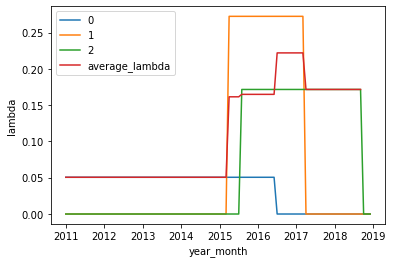

In [13]:
# intermediate plottin of computing average lambda
filename = Path('data/etas1/seism_98.6_36.8_R20_200_50.etas1')
_,_,df_etas_1,df_avg_lambda = parse_etas1_data(filename)

fig, ax = plt.subplots()
df_temp.plot(ax=ax, ylabel='lambda')
df_avg_lambda = df_avg_lambda.rename(columns={'lambda':'average_lambda'})
df_avg_lambda.plot(ax=ax, x='year_month', legend=['average'])

## Case 1: Using Injection Volume and Pore pressure to MLP model, predicting seismicity


### Train / Test split

We'll keep last 20% months of data as test and first 80% of data as training.

### Data preparataion
We'll merge the PP, injection volume and ETAS/Lambda data into a single dataframe for corresponding months for each latitude, longitude

These functions provide input/output data for ML model.  
Input: `12 months x [PP data, Inj vol] = 12 x 2 dim`  
Output: `Lambda/seismicity for 13th month = 1 x 1 dim`  

This should be flexible to support
1. Variable history window size ex: 6 months, 12 months etc..
2. Incorporate neighbor data ex: 8 neighbors (N, S, E, W, NE, NW, SE, SW) input = 12 x 8 x 2 dim
3. Enable/disable co-ordinate data as input ex: 98.6, 36.4 as additional input = 12 x 4 dim
4. Enable/disable Injection volume and Pore Pressure


In [14]:
def all_year_month_check(df, lat, lon):
    s1 = set(df.year_month)
    s2 = set(ALL_YEAR_MONTH)
    if not (s1 == s2):
#         print('%s, %s: %s'%(lat, lon, df.head()))        
#         print('%s, %s: %s'%(lat, lon, s1-s2))
#         print('%s, %s: %s'%(lat, lon, s2-s1))
        raise Exception("%s, %s: Not all year/month data present"%(lat, lon))

def get_data(data_dictionary, column_name,  lat_s, lon_s, include_neighbor=False):
    df = data_dictionary[lat_s, lon_s].sort_values(by='year_month')
    # all year month check applies only to the current co-ordinate. If the neighbor doesn't have
    # full data, we don't care, we'll just append zeros
    all_year_month_check(df, lat_s, lon_s)
    new_col_name = "%s_%s, %s"%(column_name, lat_s,lon_s)
    df = df.rename(columns={column_name: new_col_name}) 

    # print('**** 1', lat_s, lon_s)
    lat = float(lat_s)
    lon = float(lon_s)
    # print('**** 2', lat, lon)

    if include_neighbor:
        for offsets in [(-0.2,0), (+0.2,0), (0,-0.2), (0,+0.2)]:
            x, y = offsets
            lat_s = str(round(lat + x, 1))
            lon_s = str(round(lon + y, 1))
            # print('**** 3', lat_s, lon_s)
            new_col_name = "%s_%s, %s"%(column_name, lat_s,lon_s)
            key = (lat_s, lon_s)
            if key in data_dictionary:
                df_temp = data_dictionary[lat_s, lon_s].sort_values(by='year_month')                
                df_temp = df_temp.rename(columns={column_name: new_col_name}) 
                
            else:
                # if there's no neighor (in borders or no neighbor data), we'll set it as zero
                df_temp = pd.DataFrame(ALL_YEAR_MONTH, columns=['year_month']).set_index('year_month')
                df_temp[new_col_name] = 0
                df_temp
            df = df.merge(df_temp, on='year_month')

    df = df.set_index('year_month')
    return df 

In [15]:
### Function test code
df_temp_1 = get_data(INJECTION_LAT_LON_DATA, "injection_volume", "98.2", "37.0", include_neighbor=True)
df_temp_2 = get_data(PP_LAT_LON_DATA, "pp", "98.2", "37.0", include_neighbor=True)
df_temp = df_temp_1.merge(df_temp_2, on='year_month')
df_temp.head()


,"injection_volume_98.2, 37.0","injection_volume_98.0, 37.0","injection_volume_98.4, 37.0","injection_volume_98.2, 36.8","injection_volume_98.2, 37.2","pp_98.2, 37.0","pp_98.0, 37.0","pp_98.4, 37.0","pp_98.2, 36.8","pp_98.2, 37.2"
year_month,,,,,,,,,,
2011.00,2.98550,2.02295,0,3.94449,0,6.184601,0.358527,0,6.184601,0
2011.08,2.65819,1.72040,0,3.18646,0,3.743857,0.213738,0,3.743857,0
2011.17,3.30330,2.08725,0,3.67851,0,3.468061,-0.179263,0,3.668009,0
2011.25,4.10957,2.31741,0,3.52262,0,4.047226,-0.372317,0,4.254069,0
2011.33,4.89778,2.83365,0,3.83051,0,2.489007,-0.131000,0,2.695850,0


In [16]:
def all_year_month_check(df, lat, lon):
    s1 = set(df.year_month)
    s2 = set(ALL_YEAR_MONTH)
    if not (s1 == s2):
#         print('%s, %s: %s'%(lat, lon, df.head()))        
#         print('%s, %s: %s'%(lat, lon, s1-s2))
#         print('%s, %s: %s'%(lat, lon, s2-s1))
        raise Exception("%s, %s: Not all year/month data present"%(lat, lon))


# pp data: PP_LAT_LON_DATA
# inj data: INJECTION_LAT_LON_DATA
# inj data: ETAS1_LAT_LON_DATA

MONTH_WINDOW = 12
TEST_PERC = 0.2 # 20% testing

def prepare_train_test_data(lat, lon, include_neighbor=False):

    df_inj = get_data(INJECTION_LAT_LON_DATA, "injection_volume",  lat, lon, include_neighbor)    
    df_pp = get_data(PP_LAT_LON_DATA, "pp", lat, lon, include_neighbor)
    
    df_avg_lambda = ETAS1_LAT_LON_DATA[lat,lon][1].sort_values(by='year_month')
    all_year_month_check(df_avg_lambda, lat, lon)

    df_merge = df_inj.merge(df_pp, on='year_month')
    df_merge = df_merge.merge(df_avg_lambda, on='year_month')

    ##### train-test split
    # 1. select all non-nan lambda values
    # 2. select first 80% as train and remaining 20% as test

    idx = df_merge['lambda'].dropna().index
    test_split_idx = int((1-TEST_PERC)*len(idx))
    idx, test_split_idx, idx[0:test_split_idx]
    # add column label to indicate test or train
    df_merge['label'] = np.nan
    df_merge.loc[idx[0:test_split_idx], 'label'] = 'train'
    df_merge.loc[idx[test_split_idx:], 'label'] = 'test'
    
    # add lat lon data to df_merge
    df_merge['lat'] = lat
    df_merge['lon'] = lon    
    
    # we'll prepare a separate dataframe for train and test
    # these dataframes will have lat, lon, pp, inj (ex: past 12 month as list), lambda
    def prepare_train_test_df(df_merge, label='train'):
        data = []
        for idx, row in df_merge[df_merge.label==label].iterrows():
            # get last MONTH_WINDOW data for inj vol and pp

            df_merge_temp = df_merge.loc[idx-MONTH_WINDOW : idx-1]
            columns = df_merge_temp.columns
            # find all injection volume columns
            inj_vol_columns = columns[['injection_volume' in c for c in columns]]
            inj_vol = df_merge_temp[inj_vol_columns].values
            # find all pp columns
            pp_columns = columns[['pp' in c for c in columns]]
            pp = df_merge_temp[pp_columns].values

            # find all prev lambda values
            prev_lambda = df_merge_temp['lambda'].values



            lbda = df_merge.loc[idx,'lambda']
            year_month = df_merge.loc[idx,'year_month']
            
            lat = df_merge.loc[idx,'lat']
            lon = df_merge.loc[idx,'lon']
            
            # if we don't have enough month data for ex: at the start years 2011, then we ignore the data
            if len(inj_vol) != MONTH_WINDOW:
#                 print('%s, %s: Not enough data for idx=%s, year_month=%s'%(lat, lon, idx, year_month))
                continue
            lat_float = float(lat)
            lon_float = float(lon)            
            data.append([lat_float, lon_float, year_month, inj_vol, pp, prev_lambda, lbda])

        df = pd.DataFrame(data, columns = ['lat', 'lon', 'year_month', 'inj_vol', 'pp', 'prev_lambda', 'lambda'])
        return df

    df_train = prepare_train_test_df(df_merge, 'train')
    df_test = prepare_train_test_df(df_merge, 'test')
    
    return df_train, df_test


In [17]:
# We have a function to prepare train test data for given lat and lon
# we'll get train/test data for all the lat, lon co-ordinates and concatinate
# to get single train and test dataframes

len(INJECTION_LAT_LON_DATA.keys()), len(PP_LAT_LON_DATA.keys()), len(ETAS1_LAT_LON_DATA.keys())

all_co_ords = INJECTION_LAT_LON_DATA.keys()

train_data = []
test_data = []
for lat, lon in all_co_ords:
    try:
    # if 1:
        df_train, df_test = prepare_train_test_data(lat, lon, include_neighbor=True)
        train_data.append(df_train)
        test_data.append(df_test)
    # else:
    except Exception as e:
        print(str(e))
        continue
    


97.2, 35.6: Not all year/month data present
99.0, 36.4: Not all year/month data present
97.2, 35.4: Not all year/month data present
99.0, 36.6: Not all year/month data present
98.8, 36.4: Not all year/month data present


In [18]:
df_train = pd.concat(train_data)
df_test = pd.concat(test_data)

## Machine learning model

We'll build an multilayer MLP (Dense) model to predict lambda from historical(12 month window) injection volume, PP data.


In [19]:
ETAS1_LAT_LON_DATA[lat,lon][1].sort_values(by='year_month')
df_train

,lat,lon,year_month,inj_vol,pp,prev_lambda,lambda
0,96.8,36.4,2013.75,"[[1.27961, 0.0, 1.04539, 1.39446, 0.0], [1.641...","[[4.7918579999999995, 0.0, 3.998961, 13.706794...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",0.274851
1,96.8,36.4,2013.83,"[[1.64186, 0.0, 1.35435, 1.53389, 0.0], [1.484...","[[6.694805000000001, 0.0, 5.03317, 13.989468, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",0.274851
2,96.8,36.4,2013.92,"[[1.48419, 0.0, 1.22722, 1.64158, 0.0], [1.232...","[[6.784442, 0.0, 5.17107, 13.589576000000001, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",0.274851
3,96.8,36.4,2014.00,"[[1.2328, 0.0, 1.2093, 0.879274, 0.0], [1.1951...","[[6.9361299999999995, 0.0, 5.8329699999999995,...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",0.274851
4,96.8,36.4,2014.08,"[[1.19517, 0.0, 1.21349, 0.907414, 0.0], [1.42...","[[6.97061, 0.0, 5.8329699999999995, 13.237946,...","[nan, nan, nan, nan, nan, nan, nan, nan, 0.274...",0.274851
...,...,...,...,...,...,...,...
57,96.8,35.4,2016.75,"[[2.62944, 0.0, 0.0, 0.0, 1.01359], [2.54863, ...","[[15.7959, 0.0, 0.0, 0.0, 7.901400000000001], ...","[0.08009961187733064, 0.08009961187733064, 0.0...",0.080100
58,96.8,35.4,2016.83,"[[2.54863, 0.0, 0.0, 0.0, 0.963827], [2.65437,...","[[16.1889, 0.0, 0.0, 0.0, 8.294400000000001], ...","[0.08009961187733064, 0.08009961187733064, 0.0...",0.080100
59,96.8,35.4,2016.92,"[[2.65437, 0.0, 0.0, 0.0, 1.07463], [2.62847, ...","[[16.48538, 0.0, 0.0, 0.0, 8.59088], [13.83779...","[0.08009961187733064, 0.08009961187733064, 0.0...",0.080100
60,96.8,35.4,2017.00,"[[2.62847, 0.0, 0.0, 0.0, 1.04501], [2.43947, ...","[[13.83779, 0.0, 0.0, 0.0, 8.59088], [13.62405...","[0.08009961187733064, 0.08009961187733064, 0.0...",0.080100


In [20]:
df_train.to_pickle('my_df_train.pickle')
df_test.to_pickle('my_df_test.pickle')